In [4]:
import pandas as pd
data = pd.read_csv(r'/Users/liz/Code/jupyter-notebook/sklearn/2- Feature Engineering/day08_digit recognizor.csv')

In [12]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# 选取全部的特征
x = data.iloc[:,1:]
# 选取标签
y = data.iloc[:,0]
(x.shape,y.shape)

((42000, 784), (42000,))

In [ ]:
'''
过滤方法通常用作预处理步骤，特征选择完全独立于任何机器学习算法。
它是根据各种统计检验中的分数以及相关性的各项指标来选择特征。
'''

In [18]:
## Filter过滤法
# 全部特征->最佳特征子集->算法->模型评估

In [22]:
# 方差过滤
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold() # 不填则默认阈值为0
x_var0 = selector.fit_transform(x)
x_var0.shape # 特征过滤后的值为708

(42000, 708)

(784,)

In [29]:
import numpy as np
# 选取特征中的中位数
standard_var = np.median(x.var().values)
standard_var

1352.286703180131

In [32]:
# 以方差中位数作为特征相关性的阈值
x_fsvar = VarianceThreshold(standard_var).fit_transform(x)
x_fsvar.shape # 即能够过滤掉一半的特征

(42000, 392)

In [35]:
# 当特征是二分类时，特征的取值就是伯努利随机变量 Var[x] = p(1-p)
# 其中X是特征矩阵，p是二分类特征中的一类在这个特征中所占的概率
# 假设p=0.8,即二分类特征中某种分类占到80%以上的时候删除特征
x_bar = VarianceThreshold(.8 * (1 - .8)).fit_transform(x)
x_bar.shape # 删除相似度达80%以上的特征后，剩余为685

(42000, 685)

In [36]:
# KNN vs 随机森林在不通方差过滤效果下的对比
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
import numpy as np

In [37]:
x = data.iloc[:,1:]
y = data.iloc[:,0]

In [38]:
standard_var = np.median(x.var().values)
x_fsvar = VarianceThreshold(standard_var).fit_transform(x)

In [ ]:
# KNN算法，特征过滤前后用时
#======【TIME WARNING：35mins +】======#
cross_val_score(KNN(),x,y,cv=5).mean()
#python中的魔法命令，可以直接使用%%timeit来计算运行这个cell中的代码所需的时间
#为了计算所需的时间，需要将这个cell中的代码运行很多次（通常是7次）后求平均值，因此运行%%timeit的时间会远远超过cell中的代码单独运行的时间
#======【TIME WARNING：4 hours】======#
%timeit
cross_val_score(KNN(),x,y,cv=5).mean()
#======【TIME WARNING：20mins】======#
cross_val_score(KNN(),x_fsvar,y,cv=5).mean()

In [44]:
# 随机森林算法，特征过滤前后用时
cross_val_score(RFC(n_estimators=10,random_state=0),x,y,cv=5).mean()
cross_val_score(RFC(n_estimators=10,random_state=0),x_fsvar,y,cv=5).mean()

0.9388098166696807

In [45]:
# 特征相关性判断
# 1.卡方过滤
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [47]:
x_fschi = SelectKBest(chi2,k=300).fit_transform(x_fsvar,y)
x_fschi.shape # 选取相关性靠前的300个特征

(42000, 300)

In [48]:
cross_val_score(RFC(n_estimators=10,random_state=0),x_fschi,y,cv=5).mean()

0.9333098667649198

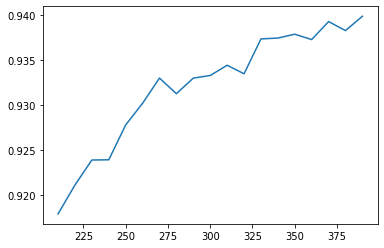

In [53]:
# 超参数k的选取
import matplotlib.pyplot as plt
score = []
for i in range(390,200,-10):
    x_fschi = SelectKBest(chi2,k=i).fit_transform(x_fsvar,y)
    once = cross_val_score(RFC(n_estimators=10,random_state=0),x_fschi,y,cv=5).mean()
    score.append(once)
plt.plot(range(390,200,-10),score)
plt.show()

In [66]:
# 通过P值进行判断,卡方判断返回，卡方值(k)与P值
chivalue,pvalues_chi = chi2(x_fsvar,y) # 特征与标签的相关性
(chivalue.shape,pvalues_chi.shape)

((392,), (392,))

In [69]:
chivalue.shape[0]
(pvalues_chi > 0.05).sum()

0

In [72]:
k_ = chivalue.shape[0] - (pvalues_chi > 0.05).sum() # 过滤掉p值小于0.05的特征数量
# 再通过SelectKBest进行选取前k个特征
x_fschi = SelectKBest(chi2,k=k_).fit_transform(x_fsvar,y)
x_fschi.shape

(42000, 392)

In [76]:
# F值检验--用来捕捉每个特征与标签之间的线性关系的过滤方法
from sklearn.feature_selection import f_classif
F,pvalues_f = f_classif(x_fsvar,y)
(F.shape,pvalues_f.shape)

((392,), (392,))

In [78]:
# 过滤方法同上
k_ = F.shape[0] - (pvalues_f > 0.05).sum()
x_fsF = SelectKBest(f_classif,k=k_).fit_transform(x_fsvar,y)
x_fsF.shape

(42000, 392)

In [79]:
# 互信息法 用来捕捉每个特征与标签之间的任意关系（包括线性和非线性关系）的过滤方法
from sklearn.feature_selection import mutual_info_classif as MIC
result = MIC(x_fsvar,y)
result

array([0.06894716, 0.08452055, 0.10657538, 0.11223374, 0.116447  ,
       0.10479306, 0.09002886, 0.05327173, 0.07614014, 0.0969441 ,
       0.11490322, 0.14893776, 0.15978893, 0.16005746, 0.16003004,
       0.12870068, 0.09259406, 0.06521079, 0.03217436, 0.02448286,
       0.06841499, 0.09982025, 0.12380853, 0.1534958 , 0.17595589,
       0.20644884, 0.22056287, 0.2257758 , 0.22370985, 0.17704858,
       0.14122854, 0.10970489, 0.08036616, 0.05806892, 0.05092111,
       0.04046143, 0.05431091, 0.07614891, 0.10057549, 0.12297718,
       0.13617313, 0.15025379, 0.16754012, 0.18236057, 0.18427141,
       0.1741774 , 0.15467679, 0.13122499, 0.11382583, 0.09559875,
       0.08101695, 0.06203413, 0.06582145, 0.04473196, 0.06316024,
       0.07221735, 0.08321708, 0.09564432, 0.1001527 , 0.11038187,
       0.10776582, 0.11222418, 0.11906166, 0.11729099, 0.11456686,
       0.11414737, 0.10942615, 0.11102179, 0.09531619, 0.07797781,
       0.07154818, 0.04236652, 0.05864219, 0.06380257, 0.07437

In [80]:
result.shape

(392,)

In [83]:
k_ = result.shape[0] - sum(result <= 0)
x_fsmic = SelectKBest(MIC,k=k_).fit_transform(x_fsvar,y)

In [84]:
## Embedded嵌入法
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC

In [85]:
RFC_ = RFC(n_estimators=10,random_state=0)
x_embedded = SelectFromModel(RFC_,threshold=0.005).fit_transform(x,y)

In [91]:
RFC_.fit(x,y).feature_importances_.mean() # 平均每个特征的重要性平均为0.0012，和为1

0.0012755102040816326

In [93]:
x_embedded.shape # 过滤后的特征为47个

(42000, 47)

In [95]:
# 利用学习曲线找出超参数最合适的值
import numpy as np
import matplotlib.pyplot as plt
threshold = np.linspace(0,(RFC_.fit(x,y).feature_importances_).max(),20)
score = []
for i in threshold:
    x_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(x,y)
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score.append(once)
plt.plot(threshold,score)
plt.show()

In [97]:
x_embedded = SelectFromModel(RFC_,threshold=0.00067).fit_transform(x,y)
x_embedded.shape

(42000, 324)

In [98]:
cross_val_score(RFC_,x_embedded,y,cv=5).mean()

0.939905083368037

In [ ]:
#======【TIME WARNING：10 mins】======# 继续缩小超参数的范围，查询最优值
score2 = []
for i in np.linspace(0,0.00134,20):
    X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score2.append(once)
plt.figure(figsize=[20,5])
plt.plot(np.linspace(0,0.00134,20),score2)
plt.xticks(np.linspace(0,0.00134,20))
plt.show()

In [100]:
x_embedded = SelectFromModel(RFC_,threshold=0.000564).fit_transform(x,y)
x_embedded.shape
cross_val_score(RFC_,x_embedded,y,cv=5).mean()

0.9408335415056387

In [101]:
## Wrapper包装法
from sklearn.feature_selection import RFE
RFC_ = RFC(n_estimators=10,random_state=0)
selector = RFE(RFC_,n_features_to_select=340,step=50).fit(x,y)

In [108]:
selector.support_.sum()
# selector.ranking_
x_wrapper = selector.transform(x) # 筛选特征
cross_val_score(RFC_,x_wrapper,y,cv=5).mean()
# 同理，可利用学习曲线找寻出最佳的特征选择个数

0.9389522459432109

In [115]:
x_wrapper.shape

(42000, 340)